In [20]:
import os
import time
import pickle
import warnings
import numpy as np
import astropy.io.fits as fits
import pyklip.fitpsf as fitpsf
import matplotlib.pylab as plt
import pyklip.instruments.MagAO as MagAO
from pyklip.klip import nan_gaussian_filter
from forwardModel import forwardModel
import GhostIsolation as ghost
import multiprocessing as mp

In [21]:
# plotting functions
def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius


def domask(img, inn=70, outt=180):
    outermask = create_circular_mask(451, 451, radius=outt, leq=True)
    img[~outermask] = np.nanmedian(img)
    mask = create_circular_mask(451, 451, radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = np.nanmedian(img)
    return masked_img

In [22]:
platescale=7.95
platescale_err=0.10
pa_offset=-0.497
pa_uncertainty=0.192

data/27Apr18/Ha/*fits
read fits file into data
created median
Calculated ghost center is 196.9191687086391 at x=383 , y=218
returning
Parameter('x_0', value=18.0)
CUT MOF FWHM IS 3.578
CUT GAU FWHM IS 4.668335349041965 5.538421812160376
FIXED MOFFAT FWHM IS 3.578
x center is Parameter('x_0', value=15.236048402477692)
y center is Parameter('y_0', value=14.583358231334328)
Parameter('x_0', value=15.236048402477692) Parameter('y_0', value=14.583358231334328)
shift number 0
shift number 100
shift number 200
shift number 300
shift number 400
created median after shifting
Calculated ghost center is 203.77492568037076 at x=383 , y=218
returning


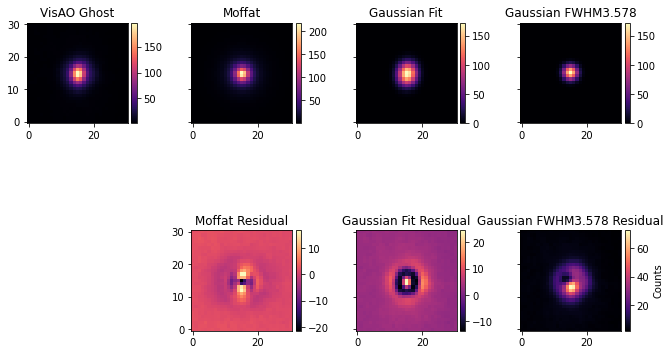

In [44]:
# loop inputs
date = '27Apr18'  # str(input('enter date in format ##Month##: '))
fwhm = 4.22  # float(input('enter dataset fwhm: '))
ann1 = 0  # int(input('enter IWA: '))
ann2 = 20  # int(input('enter OWA: '))
sep = 6  # int(input('enter sep: '))
pa = 50  # int(input('enter pa: '))

prefixes = ['Ha']#, 'Ha_60pct']#
psfplans = [['doGhost', fwhm], ['doMoffat', fwhm],
            ['doGaussian', fwhm]]#, ['doGs', fwhm]]
psfplans = [['doGaussian', fwhm]]
residuals = []
filepaths = []
outputdirs = []
for pref in prefixes:
    filepath = f'data/{date}/{pref}/*fits'
    outputdir = f'output/{date}/{pref}'
    filepaths.append(filepath)
    outputdirs.append(outputdir)
    
multipleGs = None#[fwhm,4.5,4,3.5]
    
# only need to do this once for each wavel
ghosts = []
moffs = []
gaussfits = []
gaussfwhms = []

if multipleGs is not None:
    gaussfwhms_list = []
    for fwhm in multipleGs:
        gaussfwhms = []
        for i in range(len(filepaths)):
            filepath = filepaths[i]
            outputdir = outputdirs[i]
            ghostdata, moffat, gaussfit, gaussfwhm, fwhm = ghost.ghostIsolation(filepath, 380, 220, 10, fwhm, 1, fwhm=fwhm)
            gaussfwhms.append(gaussfwhm)
            
        gaussfwhms_list.append(gaussfwhms)
        
else:
    for i in range(len(filepaths)):
        filepath = filepaths[i]
        outputdir = outputdirs[i]
        ghostdata, moffat, gaussfit, gaussfwhm, fwhm, smof = ghost.ghostIsolation(filepath, 380, 220, 10, fwhm, 1, fwhm=fwhm)
        try:
            plt.savefig(outputdir+'/'+'FM-psfs.png', dpi=300)
        except FileNotFoundError:
            os.makedirs(outputdir+'/')
            plt.savefig(outputdir+'/'+'FM-psfs.png', dpi=300)
        ghosts.append(ghostdata)
        moffs.append(smof)#moffat)
        gaussfits.append(gaussfit)
        gaussfwhms.append(gaussfwhm)

doGaussian
reading data, num files:  500
Parameters set, ready to begin forward modeling... 
saving files to: .\output/27Apr18/Ha
instrumental PSF FWHM is: 3.578
fm_class ready for KLIP
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 1256.6370614359173 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to directory /home/wbalmer21/diskShapers/forwardModel/output/27Apr18/Ha
Done constructing forward model! You are ready to MCMC.
output_prefix: output/27Apr18/Ha/
output/27Apr18/Ha/doGaussian/Ha3.578
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
time taken:  118.0  seconds
Raw X/Y Centroid = (4.583050210393935, 3.0311653312266458) with statistical error of [-0.16802129  0.17612201] pix in X and [-0.1043743   0.10206591] pix in Y
Raw Sep/P

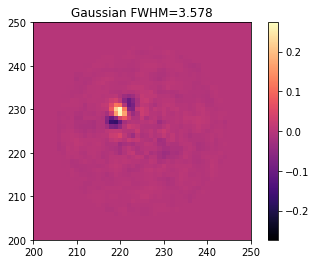

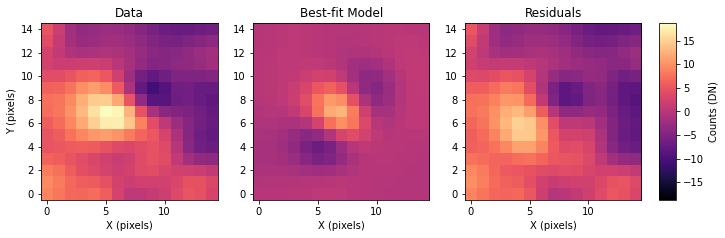

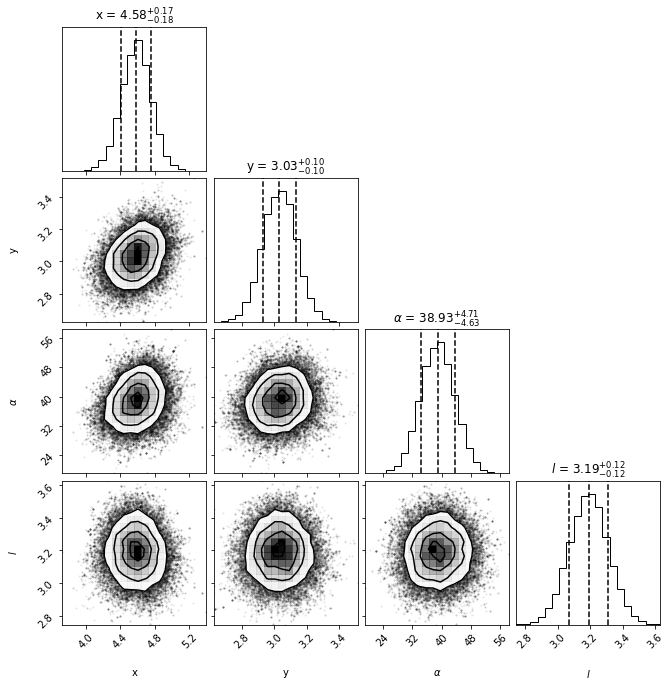

In [45]:
if multipleGs is not None:
    psfplans = []
    for i in range(len(multipleGs)):
        fwhm = multipleGs[i]
        psfs = gaussfwhms_list[i]
        plan = ['doGs',fwhm,psfs]
        psfplans.append(plan)

residuals = []
for instpsf in psfplans:
    PSFpath = instpsf[0]
    print(PSFpath)
    if PSFpath == 'doGaussian':
        outside_psfs = gaussfwhms
        FWHM = fwhm
    if PSFpath == 'doGs':
        outside_psfs = instpsf[2]
        PSFpath = 'doGaussian'
        FWHM = fwhm
    elif PSFpath == 'doGaussFit':
        outside_psfs = gaussfits
        FWHM = instpsf[1]
    elif PSFpath == 'doMoffat':
        outside_psfs = moffs
        FWHM = instpsf[1]
    elif PSFpath == 'doGhost':
        outside_psfs = ghosts
        FWHM = instpsf[1]
    
    # parameters
    KLmode = 50
    numbasis = 100#KLmode
    contrast = 1e-2
    ann1, ann2 = 0,20
    an = [ann1, ann2]
    an2 = [ann1, ann2]
    move = 1
    scale = 1
    smooth = 1#None

    cores = mp.cpu_count()
    highpass = 1.5*FWHM

    # run
    for i in range(len(filepaths)):
        filepath = filepaths[i]
        outputdir = outputdirs[i]
        prefix = prefixes[i]
        outside_psf = outside_psfs[i]
        fm = forwardModel(filepath, outputdir, prefix, KLmode, sep, pa, contrast, an, move, scale, ePSF=PSFpath, FWHM=FWHM, cores=cores, highpass=highpass, numbasis=numbasis, outside_psf=outside_psf)
        fm.prep_KLIP()
        fm.run_KLIP()

        output_prefix = outputdir+'/'
        print('output_prefix: '+output_prefix)

        # move image
        try:
            from shutil import move, copy
            src = output_prefix + prefix + "-fmpsf-KLmodes-all.fits"
            dest = src.replace(prefix + "-fmpsf-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-fmpsf-KLmodes-all.fits')
            try:
                move(src, dest)
            except OSError:
                copy(src, dest)
            src = output_prefix + prefix + "-klipped-KLmodes-all.fits"
            dest = src.replace(prefix + "-klipped-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-klipped-KLmodes-all.fits')
            move(src, dest)
        except FileNotFoundError:
            src = output_prefix + prefix + "-fmpsf-KLmodes-all.fits"
            os.mkdir(src.replace(prefix + "-fmpsf-KLmodes-all.fits", '/'+PSFpath+'/'))
            dest = src.replace(prefix + "-fmpsf-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-fmpsf-KLmodes-all.fits')
            os.rename(src, dest)
            src = output_prefix + prefix + "-klipped-KLmodes-all.fits"
            dest = src.replace(prefix + "-klipped-KLmodes-all.fits", PSFpath+'/'+prefix+str(FWHM)+'-klipped-KLmodes-all.fits')
            os.rename(src, dest)
        output_prefix_orig = output_prefix
        output_prefix = os.path.join(output_prefix, PSFpath)
        output_prefix = output_prefix+'/'+prefix+str(FWHM)
        
        print(output_prefix)

        img = fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0]
        n = np.nanmax(img)
        plt.figure()
        plt.imshow(domask(img, inn=an2[0], outt=an2[1]), origin='lower', vmin=-n, vmax=n, cmap='magma')
        plt.xlim(200, 250)
        plt.ylim(200, 250)
        plt.colorbar()
        plt.title(PSFpath.replace('do', '')+' FWHM='+str(FWHM))
        plt.savefig(output_prefix+'-FM-img-'+PSFpath.replace('do', '')+'.png', dpi=300)
        # Your variables here
        # some basics to point towards your model
        sep = sep  # only needs a guess
        pa = pa  # guess here too
        length = 2.5  # guess here also

        # set some boundaries for your MCMC
        x_range = 2  # in pixels, anywhere from 1.5-5 is reasonable
        y_range = 2  # same as x
        flux_range = [10,200] # flux can vary by an order of magnitude
        corr_len_range = 3  # between 0.3 and 30

        # and finally some parameters for the MCMC run
        nwalkers = 8

        nburn = 1000
        nsteps = 10000

        # output to save chain to
        pklout = outputdir+'/'+prefix+PSFpath.replace('do', '')+str(FWHM)+'_chain.pkl'

        # get FM frame
        fm_frame = fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0]
        fm_header = fits.getheader(output_prefix + "-fmpsf-KLmodes-all.fits")
        if smooth:
            fm_frame = nan_gaussian_filter(fm_frame, smooth)
        fm_centx = fm_header['PSFCENTX']
        fm_centy = fm_header['PSFCENTY']

        # get data_stamp frame
        data_frame = fits.getdata(output_prefix + "-klipped-KLmodes-all.fits")[0]
        data_header = fits.getheader(output_prefix + "-klipped-KLmodes-all.fits")
        if smooth:
            data_frame = nan_gaussian_filter(data_frame, smooth)
        data_centx = data_header['PSFCENTX']
        data_centy = data_header['PSFCENTY']

        # get initial guesses. Should be in the header but aren't?
        guesssep = sep
        guesspa = pa

        # create FM Astrometry object - 13 is fitboxsize
        fma = fitpsf.FMAstrometry(guesssep, guesspa, 15)

        # generate FM stamp
        # padding should be greater than 0 so we don't run into interpolation problems
        fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

        # generate data_stamp stamp
        # note that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
        # exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
        fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=3)

        # set kernel, no read noise
        corr_len_guess = length
        corr_len_label = r"$l$"
        fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

        # set bounds based on given boundaries
        fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

        t0 = time.time()

        # run MCMC fit
        fma.fit_astrometry(nwalkers=nwalkers, nburn=nburn, nsteps=nsteps, numthreads=cores, chain_output=pklout)

        t1 = time.time()
        print("time taken: ", str(np.round(t1-t0)), " seconds")

        fma.propogate_errs(star_center_err=0.1, platescale=platescale, platescale_err=platescale_err, pa_offset=pa_offset, pa_uncertainty=pa_uncertainty)
        # And third is the model comparison and residuals
        fig, resids = fma.best_fit_and_residuals()
        plt.savefig(output_prefix+'_BKA_residuals'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
        plt.show()
        fig = fma.make_corner_plot()
        plt.savefig(output_prefix+'_BKA_corner'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
        plt.show()
        
        residuals.append(resids)
        
        

In [14]:
import glob
nights = glob.glob('output/'+date+'/')
psfs = ['Ghost', 'Moffat','Gaussian']
# psfs = ['Ghost']
for night in nights:
    pikls = []
    for psf in psfs:
        pikl = glob.glob(night+prefixes[0]+'/*'+psf+'*.pkl')
        for peesef in pikl:
            pikls.append(peesef)
    print(pikls)

['output/27Apr18/Ha/HaGhost4.22_chain.pkl', 'output/27Apr18/Ha/HaMoffat4.22_chain.pkl', 'output/27Apr18/Ha/HaGaussian3.578_chain.pkl']


output/27Apr18/Ha/HaGhost4.22_chain.pkl
(8, 10000, 4)
output/27Apr18/Ha/HaMoffat4.22_chain.pkl
(8, 10000, 4)
output/27Apr18/Ha/HaGaussian3.578_chain.pkl
(8, 10000, 4)


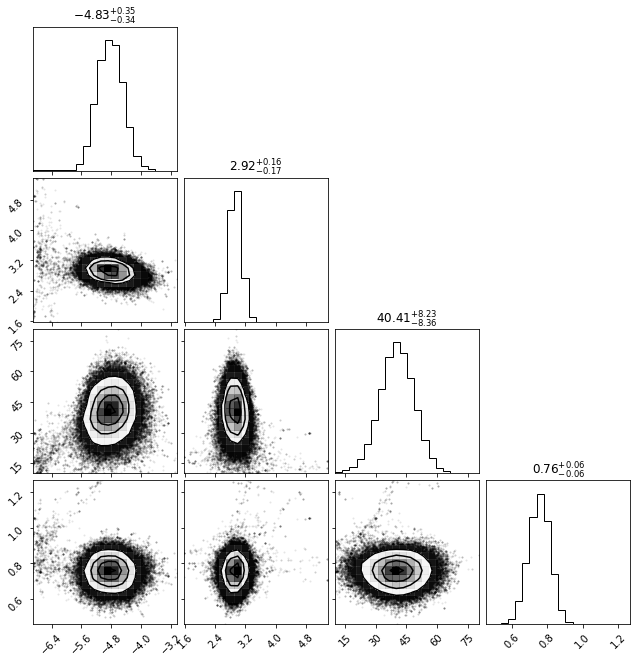

In [15]:
# We load in the results of the MCMC from the compressed pickle file
# the pyklip code has generated for us
import pandas as pd
chains = []
for pklout in pikls:
    print(pklout)
    chain = pickle.load(open(pklout, "rb"))
    chains.append(chain)
    print(chain.shape)
chain_info_ra = chains[0][:,:,0].ravel()
chain_info_dec = chains[0][:,:,1].ravel()
chain_info_alpha = chains[0][:,:,2].ravel()
chain_info_l = chains[0][:,:,3].ravel()
for chain in chains[1:]:
    chain_info_ra = np.append(chain[:,:,0].ravel(), chain_info_ra)
    chain_info_dec = np.append(chain[:,:,1].ravel(), chain_info_dec)
    chain_info_alpha = np.append(chain[:,:,2].ravel(), chain_info_alpha)
    chain_info_l = np.append(chain[:,:,3].ravel(), chain_info_l)

post = pd.DataFrame(columns=['ra', 'dec', 'alpha', 'l'])
post['ra'] = chain_info_ra-225
post['dec'] = chain_info_dec-225
post['alpha'] = chain_info_alpha
post['l'] = chain_info_l
   
import corner

corn = corner.corner(post,show_titles=True, title_kwargs={"fontsize": 12})
plt.savefig(output_prefix_orig+'_allpsf_corner.png', dpi=200)

In [16]:
class ParamRange(object):
    """
    Stores the best fit value and uncertainities for a parameter in a neat fasion

    Args:
        bestfit (float): the bestfit value
        err_range: either a float or a 2-element tuple (+val1, -val2) and gives the 1-sigma range

    Attributes:
        bestfit (float): the bestfit value
        error (float): the average 1-sigma error
        error_2sided (np.array): [+error1, -error2] 2-element array with asymmetric errors
    """
    def __init__(self, bestfit, err_range):
        self.bestfit = bestfit

        if isinstance(err_range, (int, float)):
            self.error = err_range
            self.error_2sided = np.array([err_range, -err_range])
        elif len(err_range) == 2:
            self.error_2sided = np.array(err_range)
            self.error = np.mean(np.abs(err_range))

In [17]:
import astropy.stats.circstats as circstats
x_fit = post['ra'].to_numpy()
y_fit = post['dec'].to_numpy()
x_best = np.median(post['ra'])
y_best = np.median(post['dec'])
x_1sigma_raw = np.percentile(post['ra'], [84,16]) - np.median(post['ra'])
y_1sigma_raw = np.percentile(post['dec'], [84,16]) - np.median(post['dec'])

# print("Raw X/Y Centroid = ({0}, {1}) with statistical error of {2} pix in X and {3} pix in Y".format(x_best, y_best, x_1sigma_raw, y_1sigma_raw))

# calculate sep and pa from x/y separation
sep_fit = np.sqrt((x_fit)**2 + (y_fit)**2)
# For PA compute mean using circstats package, find delta_pa between all points and the mean,
# then compute median/precentiles
pa_fit = (np.arctan2(y_fit, x_fit) - (np.pi/2.0)) % (2.0*np.pi) # Radians!
# for Bayesian, convert the chains to sep/pa to get uncertainity
pa_mean = circstats.circmean(pa_fit - np.pi) + np.pi # Circmean [-pi, pi]
d_pa = np.arctan2(np.sin(pa_fit-pa_mean), np.cos(pa_fit-pa_mean))
pa_median = np.median(d_pa) + pa_mean
pa_percentile = np.nanpercentile(d_pa, [84,16])  - np.median(d_pa) # median of d_pa should be small
pa_fit = np.degrees(pa_fit) # Convert to degrees

# calculate sep and pa statistical errors
sep_best = np.median(sep_fit)
pa_best = np.degrees(pa_median)
sep_1sigma_raw = (np.percentile(sep_fit, [84,16]) - sep_best)
pa_1sigma_raw = np.degrees(pa_percentile)

# print("Raw Sep/PA Centroid = ({0}, {1}) with statistical error of {2} pix in Sep and {3} pix in PA".format(sep_best, pa_best, sep_1sigma_raw, pa_1sigma_raw))

# store the raw sep and PA values
raw_sep = ParamRange(sep_best, sep_1sigma_raw)
raw_PA = ParamRange(pa_best, pa_1sigma_raw)

star_center_err = 0.1

sep_err_pix = (sep_1sigma_raw**2) + star_center_err**2
sep_err_pix = np.sqrt(sep_err_pix)

sep_err_mas = np.sqrt((sep_err_pix * platescale)**2 + (platescale_err * sep_best)**2)

pa_fit = np.radians((pa_fit + pa_offset) % 360) # Convert back to radians for circstats
pa_mean = circstats.circmean(pa_fit - np.pi) + np.pi # Circmean [-pi, pi]
d_pa = np.arctan2(np.sin(pa_fit-pa_mean), np.cos(pa_fit-pa_mean))

pa_median = np.median(d_pa) + pa_mean
pa_best = np.degrees(pa_median)

pa_fit = np.degrees(pa_fit) # Convert back to degrees

pa_err = np.radians(pa_1sigma_raw)**2 + (star_center_err/sep_best)**2 + np.radians(pa_uncertainty)**2
pa_err = np.sqrt(pa_err)
pa_err_deg = np.degrees(pa_err)

sep_err_pix_avg = np.mean(np.abs(sep_err_pix))
pa_err_deg_avg = np.mean(np.abs(pa_err_deg))

# print("Sep = {0} +/- {1} ({2}) pix, PA = {3} +/- {4} ({5}) degrees".format(sep_best, sep_err_pix_avg, sep_err_pix, pa_best, pa_err_deg_avg, pa_err_deg))

sep = ParamRange(sep_best, sep_err_pix)
PA = ParamRange(pa_best, pa_err_deg)

sep_err_mas_avg = np.mean(np.abs(sep_err_mas))
# print("Sep = {0} +/- {1} ({2}) mas, PA = {3} +/- {4} ({5}) degrees".format(sep_best*platescale, sep_err_mas_avg, sep_err_mas, pa_best, pa_err_deg_avg, pa_err_deg))
# overwrite sep values with values converted to milliarcseconds
sep = ParamRange(sep_best*platescale, sep_err_mas)

result = pd.DataFrame(index=[date])
result['sep'] = [sep.bestfit]
result['seperr'] = [sep.error]
result['pa'] = [PA.bestfit]
result['paerr'] = [PA.error]
result['alpha'] = [np.nanmedian(post['alpha'])]
result['alphaerr'] = [np.nanstd(post['alpha'])]
result

,sep,seperr,pa,paerr,alpha,alphaerr
27Apr18,44.957846,2.773318,58.31543,2.281692,40.414073,8.446722


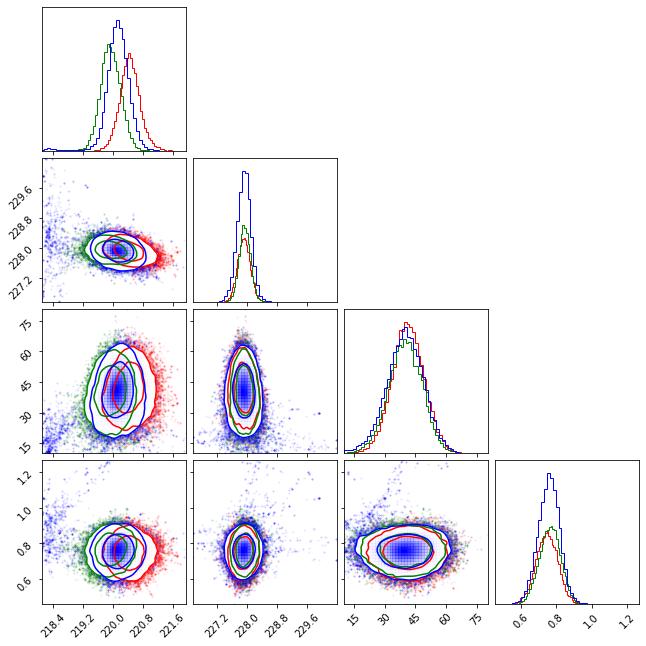

In [18]:
colors = ['red', 'green', 'blue', 'purple']
for j in range(len(chains)):
    color = colors[j]
    if j == 0:
        post = pd.DataFrame(columns=['ra', 'dec', 'alpha', 'l'])
        for i in range(chains[j].shape[2]):
            post[post.columns[i]] = chains[j][:,:,i].ravel()
        fig = corner.corner(post, color=color, plot_datapoints=True, fill_contours=False, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16})#, range=[[218,226],[223.5,229.5],[0,100],[1,2.5]])
    else:
        post = pd.DataFrame(columns=['ra', 'dec', 'alpha', 'l'])
        for i in range(chains[j].shape[2]):
            post[post.columns[i]] = chains[j][:,:,i].ravel()
        corner.corner(post, fig=fig, color=color, plot_datapoints=True, fill_contours=False, bins=50, smooth=1.0, levels=[0.68,0.95], label_kwargs={"fontsize": 16})

# plt.savefig('test_multicorner.png', dpi=200)
plt.savefig(output_prefix_orig+'_allpsf_multicorner.png', dpi=200)

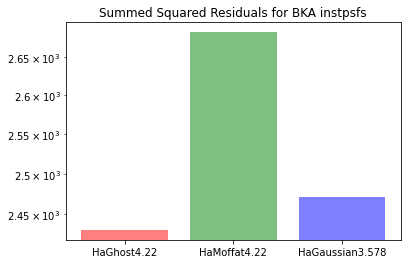

In [19]:
# residuals = residuals[0:2]+residuals[3:]
colors = ['red', 'green', 'blue']
methods = []
j = 0
for i in pikls:
    method = i.split('/')[-1]
    method = method.replace('_chain.pkl','')
    methods.append(method)
sumsqs = []
for resid in residuals:
    sumsq = np.nansum(resid**2)
    sumsqs.append(sumsq)
plt.bar(np.arange(len(sumsqs)), sumsqs, color=colors, align='center', alpha=0.5)
plt.yscale('log')
plt.xticks(np.arange(len(sumsqs)), methods)

plt.title('Summed Squared Residuals for BKA instpsfs')
# plt.savefig('instpsf_18May15_resids.png')
plt.savefig(output_prefix_orig+'_allpsf_resids.png', dpi=200)